In [23]:
import os
print(os.getcwd())


/Users/lenaigoumrane/DSML_Team_Assignment


/var/folders/n5/7nf21hjj3t191b7rs6zzhg800000gn/T/ipykernel_8455/2349787803.py:55: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  city_boundary = community_areas.to_crs(epsg=26971).unary_union


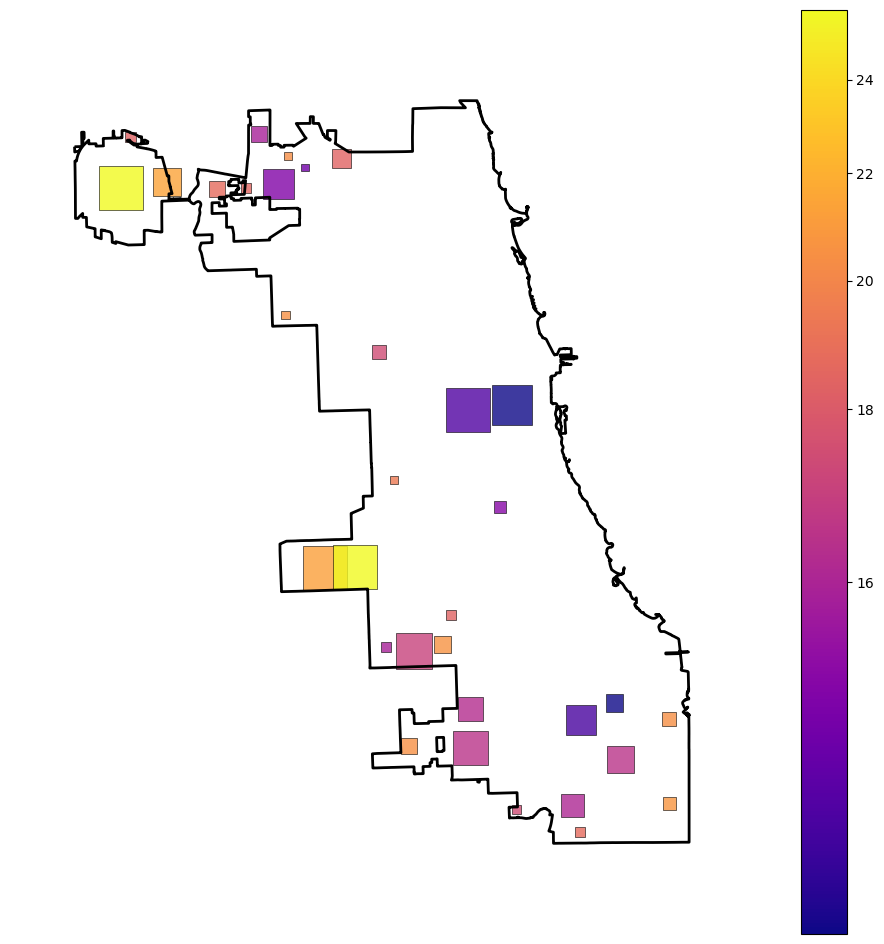

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import DBSCAN
import numpy as np

# Load CSV with all data (no sampling)
df = pd.read_csv('Ridehailing_Chicago_sample327k.csv')

# Drop missing pickup locations
df = df.dropna(subset=['pickup_centroid_location'])

# Convert WKT to geometry points
df['geometry'] = df['pickup_centroid_location'].apply(wkt.loads)

# Create GeoDataFrame in WGS84
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# Calculate trip duration in minutes
gdf['trip_duration_min'] = gdf['trip_seconds'] / 60

# Project to metric CRS (for clustering and plotting)
gdf_proj = gdf.to_crs(epsg=26971)

# Extract coordinates for clustering
coords = np.array(list(zip(gdf_proj.geometry.x, gdf_proj.geometry.y)))

# Run DBSCAN clustering (eps ~1km, min_samples=30)
dbscan = DBSCAN(eps=1000, min_samples=30)
clusters = dbscan.fit_predict(coords)
gdf_proj['cluster'] = clusters

# Remove noise points
clustered = gdf_proj[gdf_proj['cluster'] != -1]

# Calculate cluster centroids, average trip duration, and cluster size
cluster_stats = clustered.groupby('cluster').agg({
    'geometry': lambda x: x.geometry.values.union_all().centroid,
    'trip_duration_min': 'mean',
    'cluster': 'count'
}).rename(columns={'cluster': 'size'})


cluster_gdf = gpd.GeoDataFrame(cluster_stats, geometry='geometry', crs=gdf_proj.crs)

# Make rectangles bigger by increasing marker size (let's cap max to 1000)
cluster_gdf['marker_size'] = cluster_gdf['size'].clip(upper=1000)

# Load Chicago community areas shapefile (adjust filename)
community_areas = gpd.read_file('geo_export_50ab99d6-d6c7-45db-a4d8-04e55c03bdfc.shp')

# Dissolve all community polygons into single city boundary polygon
city_boundary = community_areas.to_crs(epsg=26971).unary_union

# Prepare plot
fig, ax = plt.subplots(figsize=(12, 12))

# Color scale limits
vmin = cluster_gdf['trip_duration_min'].quantile(0.05)
vmax = cluster_gdf['trip_duration_min'].quantile(0.95)
norm = colors.PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)

# Plot cluster squares
cluster_gdf.plot(
    ax=ax,
    marker='s',
    column='trip_duration_min',
    cmap='plasma',
    norm=norm,
    markersize=cluster_gdf['marker_size'],
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5,
    legend=True,
)

# Plot city boundary outline
gpd.GeoSeries([city_boundary]).boundary.plot(ax=ax, edgecolor='black', linewidth=2)

ax.axis('off')

# Add padding
xlim = ax.get_xlim()
ylim = ax.get_ylim()
x_pad = (xlim[1] - xlim[0]) * 0.05
y_pad = (ylim[1] - ylim[0]) * 0.05
ax.set_xlim(xlim[0] - x_pad, xlim[1] + x_pad)
ax.set_ylim(ylim[0] - y_pad, ylim[1] + y_pad)

plt.show()
